# Rental Listing Price Model

Below are the steps taken to build our regression model which will be used to predict effective prices for prospective rental listings.

## Preparing the Data

First we need to clean and standardize the data scraped from the rental listing site in order to have the model train on it.

In [63]:
from data_cleaner import get_cleaned_data, flatten_data
import pandas as pd
import numpy as np
import os

# from google.colab import files
# uploaded = files.upload()

### Data Cleaning
`get_cleaned_data()` removes invalid and outlier data including blanks and data for single room listings. It also formats the building and unit amenities by making each column a dict that contains the relevant amenities as keys with a value of 1 if the listing has it, else 0.

`flatten_data()` flattens the building and unit amenities to put individual amenities into their own columns, essentially flattening the building and unit amenities dicts into separate columns in each row.

In [64]:
pd.set_option('display.max_columns', None)

cleaned_data = get_cleaned_data()
flattened_data = flatten_data(cleaned_data)
df = pd.DataFrame(flattened_data)

print(len(df))

df.to_excel("cleaned_data.xlsx", index=False)

3704


In [65]:
print("Printing columns:")
print(df.columns)

Printing columns:
Index(['Building', 'Address', 'City', 'Listing', 'Bed', 'Bath', 'SqFt',
       'Price', 'Pets', 'Latitude', 'Longitude', 'Balcony', 'In Unit Laundry',
       'Air Conditioning', 'High Ceilings', 'Furnished', 'Hardwood Floor',
       'Controlled Access', 'Fitness Center', 'Swimming Pool', 'Roof Deck',
       'Storage', 'Residents Lounge', 'Outdoor Space'],
      dtype='object')


In [66]:
print("Printing first 2 rows:")
print(df.head(2))

Printing first 2 rows:
             Building                                  Address     City  \
0  20 Samuel Wood Way  20 Samuel Wood Way, Toronto, ON M9B 0C8  Toronto   
1  20 Samuel Wood Way  20 Samuel Wood Way, Toronto, ON M9B 0C8  Toronto   

     Listing  Bed  Bath  SqFt  Price  Pets  Latitude  Longitude  Balcony  \
0     Studio    0   1.0   370   2225     0  43.63526  -79.53992        0   
1  1 Bedroom    1   1.0   540   2625     0  43.63526  -79.53992        0   

   In Unit Laundry  Air Conditioning  High Ceilings  Furnished  \
0                0                 0              0          0   
1                0                 0              0          0   

   Hardwood Floor  Controlled Access  Fitness Center  Swimming Pool  \
0               0                  1               1              0   
1               0                  1               1              0   

   Roof Deck  Storage  Residents Lounge  Outdoor Space  
0          0        1                 1             

### The `Building` and `UnitType` class

For our purposes, we want to group the data by building type, unit type, and city as three major parameters. We created the `Building`, `UnitType`, `City` classes to group data together cleanly. This will become useful when dividing our data into a training and test set.

The `Building` class encompasses the relationship between a building name and the different types of units in it.

The `UnitType` class represents the different types of units where units are distinguished by number of bedrooms.

The `City` class contains all the `Building` values associated with a specific city.

In [67]:
from constants import TableHeaders
from classes import UnitType, Building, City

In [68]:
cities: list[City] = []

# Filter out listings with prices greater than $5K - these extreme values are outliers
df = df[df[TableHeaders.PRICE.value] < 5000]

# Group data by city to extract city specific insights
city_groups = df.groupby(TableHeaders.CITY.value)

for city_name, city_df in city_groups:
    current_city = City(city_name)
    # Group city data by building name to extract building specific insights
    building_groups = city_df.groupby(TableHeaders.BUILDING.value)

    # Create an intermediary tuple to record number of available units and sort buildings accordingly
    # When displaying overarching insights for an area, buildings with more units will be more informational
    buildings_tuples = [(building, building_df, len(building_df)) for building, building_df in building_groups]
    buildings_tuples.sort(key = lambda x: x[2], reverse=True)

    for building_name, building_df, num_units in buildings_tuples:

        current_building: Building = Building(building_name, city_name)
        # Group by bed type within this building
        bed_groups = building_df.groupby(TableHeaders.BED.value)
        for bed, unit_df in bed_groups:
            current_building.add_unit_type(bed=bed, unit_df=unit_df)

        current_city.add_building(current_building)
    cities.append(current_city)

Since we want to partition the data into a test and train set with an even 20% split based on the unit type, let's remove the entries that have less than 5 listings for that unit type.

In [69]:
standardized_df = df.copy()
for city_name, city_df in city_groups:
    unit_groups = city_df.groupby(TableHeaders.BED.value)
    for unit_type, unit_df in unit_groups:
        # Filter out the unit listings that have less than 5 entries for that unit type
        # since it won't have sufficient data to split between testing and training
        if len(unit_df) < 5:
            # print(city_name, unit_type, len(unit_df))
            standardized_df = standardized_df.loc[
                ~((standardized_df[TableHeaders.CITY.value] == city_name) &
                (standardized_df[TableHeaders.BED.value] == unit_type))
            ]

In [70]:
for city in cities:
    print(f"City: {city.name}")
    for building in city.buildings[:5]:
        print(building)

City: Edmonton
Building: Citizen on Jasper
Total Units: 75
Overall Average SqFt: 648.60
Overall Average Price: 2016.79
Overall Price Per SqFt: 3.11
-----------------------------------
Bedroom Type: 1 beds
 - Units: 61
 - Average SqFt: 585.95
 - Average Price: 1873.16
 - Price per SqFt: 3.20
-----------------------------------
Bedroom Type: 2 beds
 - Units: 13
 - Average SqFt: 905.77
 - Average Price: 2579.62
 - Price per SqFt: 2.85
-----------------------------------
Bedroom Type: 3 beds
 - Units: 1
 - Average SqFt: 1127.00
 - Average Price: 3461.00
 - Price per SqFt: 3.07
-----------------------------------

Building: Stadium Yards 
Total Units: 14
Overall Average SqFt: 743.71
Overall Average Price: 1717.14
Overall Price Per SqFt: 2.31
-----------------------------------
Bedroom Type: 0 beds
 - Units: 2
 - Average SqFt: 500.00
 - Average Price: 1350.00
 - Price per SqFt: 2.70
-----------------------------------
Bedroom Type: 1 beds
 - Units: 4
 - Average SqFt: 603.00
 - Average Price:

## Training the Model

In [71]:
from sklearn.model_selection import train_test_split
city_groups = standardized_df.groupby(TableHeaders.CITY.value)
master_train_df = pd.DataFrame()
master_test_df = pd.DataFrame()
for city_name, city_df in city_groups:
    train_df, test_df = train_test_split(city_df, test_size=0.2, random_state=42, stratify=city_df[TableHeaders.BED.value])

    # Concatenate the individual city train and test sets with the master DataFrames
    master_train_df = pd.concat([master_train_df, train_df], ignore_index=True)
    master_test_df = pd.concat([master_test_df, test_df], ignore_index=True)

# print(len(master_train_df.loc[master_train_df[TableHeaders.BED.value] == 1]))
# print(len(master_test_df.loc[master_test_df[TableHeaders.BED.value] == 1]))
# print(len(master_train_df.loc[master_train_df[TableHeaders.BED.value] == 2]))
# print(len(master_test_df.loc[master_test_df[TableHeaders.BED.value] == 2]))

In [72]:
import torch
# Assuming 'target_column' is the name of your target variable
dropped_columns = [
    TableHeaders.PRICE.value,
    TableHeaders.BUILDING.value,
    TableHeaders.CITY.value,
    TableHeaders.LISTING.value,
    TableHeaders.ADDRESS.value,
    # TableHeaders.LAT.value,
    # TableHeaders.LON.value,
    # TableHeaders.PETS.value,
    # TableHeaders.SQFT.value,
    # TableHeaders.BED.value,
    # TableHeaders.BATH.value,
    # 'Balcony',
    # 'In Unit Laundry',
    # 'Air Conditioning',
    # 'High Ceilings',
    # 'Furnished',
    # 'Hardwood Floor',
    # 'Controlled Access',
    # 'Fitness Center',
    # 'Swimming Pool',
    # 'Roof Deck',
    # 'Storage',
    # 'Residents Lounge',
    # 'Outdoor Space',
]

# updated_df = master_train_df.loc[master_train_df[TableHeaders.CITY.value] == 'toronto']

updated_train_df = master_train_df.drop(dropped_columns, axis=1)
updated_test_df = master_test_df.drop(dropped_columns, axis=1)

X_train = torch.tensor(updated_train_df.values).float()
y_train = torch.tensor(master_train_df[TableHeaders.PRICE.value].values).float()

X_test = torch.tensor(updated_test_df.values).float()
y_test = torch.tensor(master_test_df[TableHeaders.PRICE.value].values).float()

# y_train = y_train.view(y_train.shape[0],1)
# y_test = y_test.view(y_test.shape[0],1)

print(X_train[0], y_train[0])

tensor([   1.0000,    1.0000,  451.0000,    1.0000,   53.5510, -113.4975,
           1.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           1.0000,    0.0000,    0.0000,    0.0000,    1.0000,    0.0000,
           0.0000]) tensor(1000.)


In [73]:
from dataset import RentalDataset
from torch.utils.data import DataLoader

train_dataset = RentalDataset(X_train, y_train)
test_dataset = RentalDataset(X_test, y_test)

batch_size = 64  # Choose a batch size that fits your model and training process

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

NUM_EPOCHS = 25
LEARNING_RATE = 0.001
LAMBDA_L1 = 0.01  # Regularization strength

class RegressionModelV2(nn.Module):
    def __init__(self, input_size):
        super(RegressionModelV2, self).__init__()
        # Increasing the complexity of the model
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)  # Single output for regression

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)  # No activation function for the last layer in regression
        return x

input_size = X_train.shape[1]

# Replace input_size with the actual size of your input features
model = RegressionModelV2(input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Learning rate can be adjusted

model.train()

for epoch in range(NUM_EPOCHS):
  for input, targets in train_loader:
    prediction = model(input)
    loss = criterion(targets, prediction)

    l1_penalty = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    total_loss = loss + LAMBDA_L1 * l1_penalty

    optimizer.zero_grad()  # Clear existing gradients
    total_loss.backward()       # Backpropagation
    optimizer.step()      # Update model parameters

  # Optional: Print the loss every epoch
  print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {total_loss.item():.4f}')

/Users/shivamjindal/Documents/Projects/Real Estate Scraper/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/shivamjindal/Documents/Projects/Real Estate Scraper/env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/25], Loss: 7468230.0000
Epoch [2/25], Loss: 738296.6875
Epoch [3/25], Loss: 1322286.2500
Epoch [4/25], Loss: 1622845.3750
Epoch [5/25], Loss: 691694.8125
Epoch [6/25], Loss: 820698.9375
Epoch [7/25], Loss: 1318797.5000
Epoch [8/25], Loss: 721329.4375
Epoch [9/25], Loss: 656228.6250
Epoch [10/25], Loss: 1838067.6250
Epoch [11/25], Loss: 623831.8750
Epoch [12/25], Loss: 793142.7500
Epoch [13/25], Loss: 1412016.3750
Epoch [14/25], Loss: 2253569.5000
Epoch [15/25], Loss: 569338.6875
Epoch [16/25], Loss: 797851.8750
Epoch [17/25], Loss: 531907.4375
Epoch [18/25], Loss: 854410.1250
Epoch [19/25], Loss: 340459.0000
Epoch [20/25], Loss: 2040562.1250
Epoch [21/25], Loss: 973894.3750
Epoch [22/25], Loss: 567138.3125
Epoch [23/25], Loss: 1138815.3750
Epoch [24/25], Loss: 674764.7500
Epoch [25/25], Loss: 1041746.8750


In [83]:
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Gradient computation is not needed for evaluation
  # Assuming you have tensors 'predictions' and 'actuals' for your test set
  predictions = model(X_test)  # X_test is your input tensor for the test set
  actuals = y_test  # y_test is the corresponding actual values tensor for the test set

  # Detach predictions and actuals from the computation graph if they require gradients
  predictions = predictions.detach()
  actuals = actuals.detach()

  # Convert to numpy arrays if needed
  predictions_np = predictions.numpy()
  actuals_np = actuals.numpy()

  # Calculate MSE and RMSE
  mse = mean_squared_error(actuals_np, predictions_np)
  rmse = sqrt(mse)

  # Calculate MAE
  mae = torch.mean(torch.abs(predictions - actuals)).item()

  # Calculate R-squared
  r2 = r2_score(actuals_np, predictions_np)

  print(f'MAE: {mae}')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'R-squared: {r2}')
  # Code to evaluate the model on the test set

MAE: 724.4678344726562
MSE: 926555.0625
RMSE: 962.5773020905906
R-squared: -0.2522552912399656


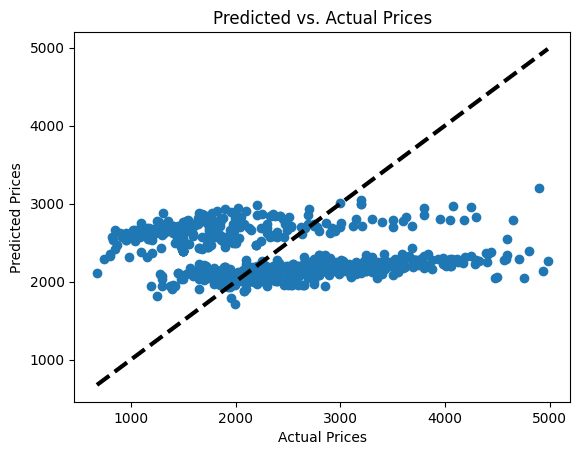

In [76]:
import matplotlib.pyplot as plt

# Assuming y_test is your actual values and predictions is your model's predictions
plt.scatter(y_test, predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs. Actual Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Diagonal line
plt.show()

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regression_model = LinearRegression()

regression_model.fit(X_train, y_train)

predictions = regression_model.predict(X_test)

print(f"{regression_model.score(X_test, y_test):.4f}")

0.7943


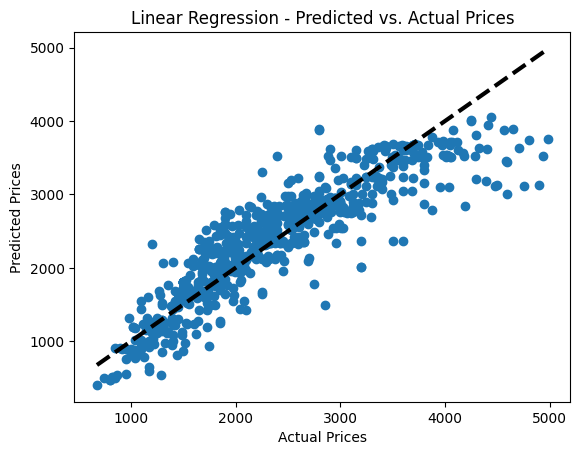

In [78]:
import matplotlib.pyplot as plt

plt.scatter(y_test, predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression - Predicted vs. Actual Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Diagonal line
plt.show()

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Create the Random Forest classifier
random_forest = RandomForestRegressor(n_estimators=500, random_state=42)

# Train the model
random_forest.fit(X_train, y_train)

# Predict using the test set
predictions = random_forest.predict(X_test)

# Evaluate accuracy
print(f"{random_forest.score(X_test, y_test):.4f}")

0.9162


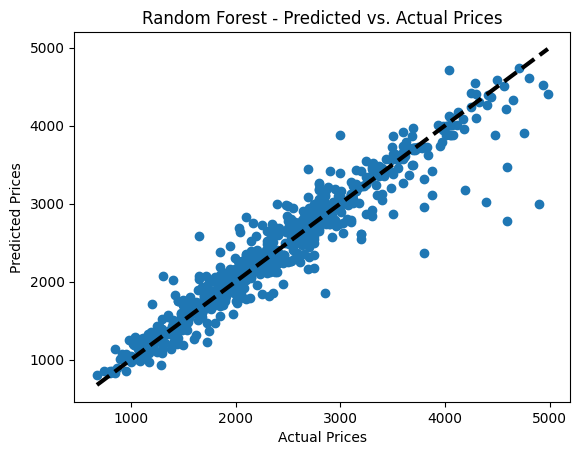

In [80]:
import matplotlib.pyplot as plt

# Assuming y_test is your actual values and predictions is your model's predictions
plt.scatter(y_test, predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest - Predicted vs. Actual Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Diagonal line
plt.show()

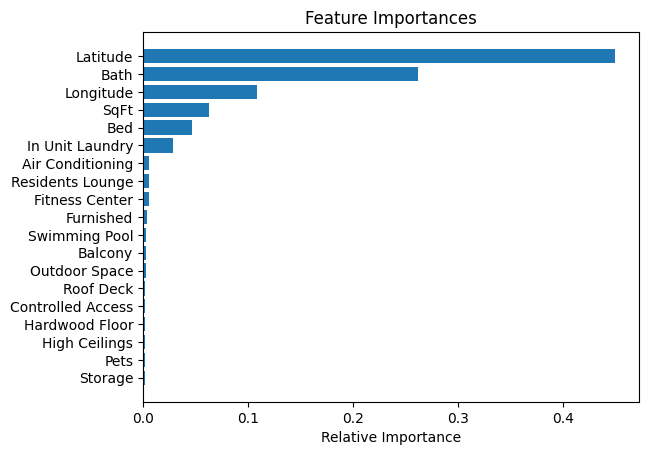

In [81]:
import numpy as np

# Assuming 'rf_model' is your trained Random Forest model and 'feature_names' is the list of feature names
importances = random_forest.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [updated_train_df.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [82]:
from joblib import dump

# Save random forest model
dump(random_forest, 'random_forest_model.joblib')

['random_forest_model.joblib']